In [5]:
import datetime
import math
from itertools import product
from random import choices, randint
from typing import List, Tuple

import numpy as np
import shapely.affinity as affinity
import shapely.geometry as geo
import vsketch
from sklearn.neighbors import NearestNeighbors


In [36]:
# helper funcs, ignore
DISPLAY_RATIO = 1.5

def display(sketch):
    return sketch.display("matplotlib", fig_size=(6*DISPLAY_RATIO,4*DISPLAY_RATIO))

## CANVAS

You can declare the size in any units. We'll use 6in x 4in.  We can also automatically center anything drawn to the canvas. One important note: (0, 0) is the upper left corner. We'll draw a line there just for an example.


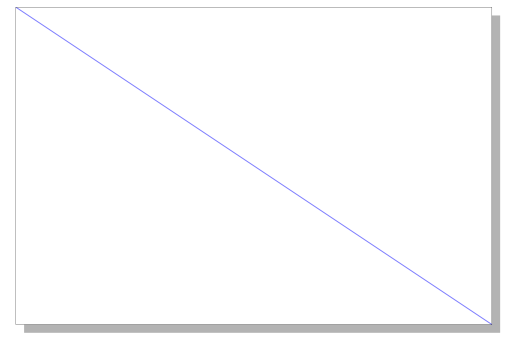

In [37]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

vsk.line(0, 0, W, H)

display(vsk)

## Borders

To make sure our drawing does not go past the edge of the canvas, I always like to include a border. In the end result, we will use the border and the _intersection_ of any objects drawn to canvas to plot. Meaning, only objects _inside_ the border will be drawn. 

Below we'll create and display the border object.

## Shapely

`vsketch` provides some primitives like lines and circles, but `shapely` is a much more powerful way of making and creating objects because you can apply set-theoretic operations to them, which allows you to combine them in interesting ways. This is how we create the _border_ object. `vsketch` has an API for drawing _ANY_ shapely object, which is what we'll use.

![](https://shapely.readthedocs.io/en/stable/_images/intersection-sym-difference.png)

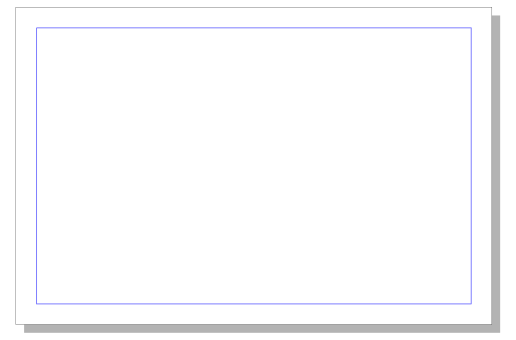

In [38]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

MARGIN = 25
# linear ring is a connected set of lines that form a "ring" (i.e. the first point connects to the last)
BORDER = geo.LinearRing(
    [
        (MARGIN, MARGIN),
        (MARGIN, H - MARGIN),
        (W - MARGIN, H - MARGIN),
        (W - MARGIN, MARGIN),
    ]
)
# There are cases where we want to use a Polygon over the LinearRing object
# but it doesn't matter for our application
BORDER_POLYGON = geo.Polygon(BORDER)

vsk.geometry(BORDER_POLYGON)
display(vsk)


## Shapes

Shapes are fun! There are many different ways to construct them based on different shape definitions. We want to create 3 helper functions for our shapes that take the same arguments, so that we can randomly select from them for our shape drawing and pass them the same type of values across functions. Our functions will take a center point for drawing, and a "radius" -- the furthest point from the center to a point on the shape.

A circle is created by selecting a single point, then drawing a buffer (radius) around it. Since a circle is an "infinite sided polygon", we actually approximate a circle by declaring a resolution and then connecting that many points. In case this is mind boggling, try thinking about how long it would take for your computer to draw an actual infinite sided polygon (forever).

One weird thing here is that we create a _diamond_ by drawing a circle, but lowering the resolution to `1`. This is a representation of a circle with only 4 points representing it (thus a diamond). 

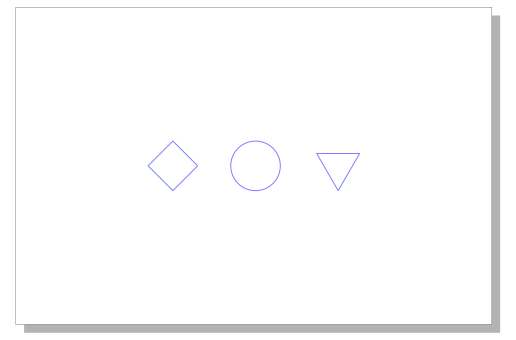

In [39]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

def circle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 16)

def diamond(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 1)

# https://stackoverflow.com/q/65544295
def triangle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    side_length = radius * math.sqrt(3)
    # Calculate three vertices of the container triangle
    a = [center[0], center[1] + (math.sqrt(3) / 3) * side_length]  # Top vertex
    b = [
        center[0] - (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]  # Bottom left vertex
    c = [
        center[0] + (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
display(vsk)
    return geo.Polygon([a, b, c])


shapefuncs = [diamond, circle, triangle]

centers = [(100, 100), (200, 100), (300, 100)]

for shape, center in zip(shapefuncs, centers):
    vsk.geometry(shape(center, 30))

display(vsk)

## A Grid
There are many ways to draw a grid. We'll parameterize ours by the desired radius of shapes we want. Starting at the margins, how many shapes can can we draw with a desired radius, placing them `SPACING` units apart until the margin on the other side? Note this will not be totally even, so the final `center`ing really helps us out. I've turned off `center` for this sketch to illustrate.

## Layers
We'll also see our first use of layers here. I will put the border in a separate "layer" so we can visualize it distinctly. We will use layers in an actual plot to indicate things that should be drawn with a different pen.

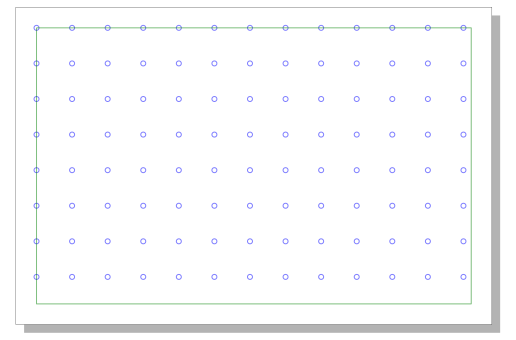

In [43]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=False)

MARGIN = 25

RADIUS = 21
SPACING = RADIUS * (2 + 0.05)

xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
points = []
for x, y in product(xrange, yrange):
    points.append((x, y))

vsk.stroke(1)
for p in points:
    vsk.geometry(geo.Point(*p).buffer(3))

vsk.stroke(2)
vsk.geometry(BORDER_POLYGON)

display(vsk)


## Background Fill with Lines

This we will create manually. There are tools to automatically "fill" polygons depending on the pen width, but since we want a specific pattern, we will have to write our own fill pattern.

What we'll do to fill the shapes is create our lined fill pattern, then for each shape, find the intersection of that shape with a line fill. That will essentially "fill" the shape with that pattern.

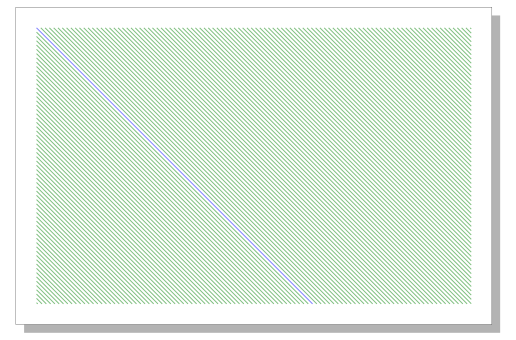

In [53]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

# The "step" should be the pen width * 2
# That way, we have a "gap" of exactly the pen width
vsk.penWidth("0.5mm")
step = vsk.strokePenWidth * 2

vertical_lines = []
diag_right_lines = []
diag_left_lines = []
# Draw vertical lines, top to bottom, from the left to the right of the canvas
for x in np.arange(0, max_dim, step=step):
    vertical_lines.append(geo.LineString([(x, 0), (x, max_dim)]))

# Draw a "template" line from the upper-left diagonal down right
diag_right_base = geo.LineString([(0, 0), (max_dim, max_dim)])
diag_right_lines = [diag_right_base]

# Draw a template line from the lower-left diagonal up right
diag_left_base = geo.LineString([(0, max_dim), (max_dim, 0)])
diag_left_lines = [diag_left_base]

# For each diagonal template line, make copies above and below that diagonal
# Note that this arange is way too far, so we'll cheat and just find the intersection
# With the border
for r in np.arange(step, max_dim, step=step):
    diag_right_lines.append(affinity.translate(diag_right_base, r*math.sqrt(step/2), 0))
    diag_right_lines.append(affinity.translate(diag_right_base, 0, r*math.sqrt(step/2)))
    diag_left_lines.append(affinity.translate(diag_left_base, -r*math.sqrt(step/2), 0))
    diag_left_lines.append(affinity.translate(diag_left_base, 0, r*math.sqrt(step/2)))

layer_lines = [vertical_lines, diag_right_lines, diag_left_lines]

# If you want to see all lines, set this to true
# otherwise, we'll illustrate the template + translations
DRAW_ALL_LINES = False

if DRAW_ALL_LINES:
    for i, layer in enumerate(layer_lines, 1):
        vsk.stroke(i)
        vsk.geometry(BORDER_POLYGON.intersection(geo.MultiLineString(layer)))
else:
    for i, line in enumerate(diag_right_lines):
        if i == 0:
            vsk.stroke(1)
            vsk.geometry(BORDER_POLYGON.intersection(line))
        else:
            vsk.stroke(2)
            vsk.geometry(BORDER_POLYGON.intersection(line))

display(vsk)


## Voronoi


Going back to our grid, we need a way to declare "neighborhoods" where shapes are roughly the same. In geometry land, this is done using a Voronoi diagram. 

> a Voronoi diagram is a partition of a plane into regions close to each of a given set of objects.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Euclidean_Voronoi_diagram.svg/1200px-Euclidean_Voronoi_diagram.svg.png" width="400">

Since we're data scientists, we might also know this by another name...

![](https://i.imgflip.com/5kcmna.jpg)

Each "point" here can be thought of as a label for k-nearest-neighbors. If for some new point we want to know how it should be labeled, we ask "what is the label of the closest point to this new point?" - aka, k=1 in KNN.

We'll build this on our grid and illustrate below.

For our application, to add some randomness we will randomly select N points from the grid to be our "centroids". Then, for each other point in the grid, we will ask which centroid is closest.

We'll repeat this process for each layer, so each layer should have a different set of neighborhoods when the points change.

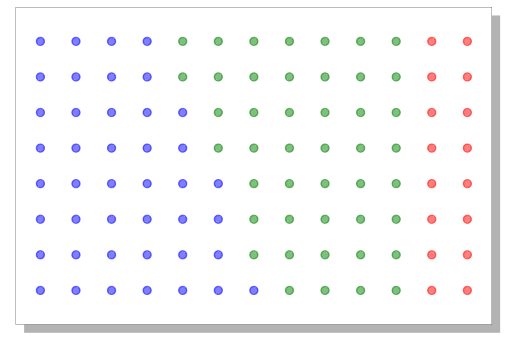

In [58]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

MARGIN = 25

RADIUS = 21
SPACING = RADIUS * (2 + 0.05)

xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
points = []
for x, y in product(xrange, yrange):
    points.append((x, y))

def knn_grid(
    grid_points: List[Tuple[float, float]], n_centers: int = 3, metric: str = "euclidean"
) -> List[int]:
    centers = choices(grid_points, k=n_centers)  # choose k points to be "centers"
    neigh = NearestNeighbors(n_neighbors=1, metric=metric)
    neigh.fit(centers)  # fit knn on those centers as the 'label'
    # for each point, return the 1st nearest neighbor
    closest_point = neigh.kneighbors(points, 1, return_distance=False)
    labels = list(c[0] for c in closest_point)
    return labels

labels = knn_grid(points)

for p, label in zip(points, labels):
    vsk.stroke(label + 1)
    vsk.fill(label+1)
    vsk.geometry(geo.Point(*p).buffer(5))

display(vsk)


{0, 1, 2}
l1 shapes generated
{0, 1, 2}
l2 shapes generated
{0, 1, 2}
l3 shapes generated
calc intersection 1
calc intersection 2
Finished Calculating


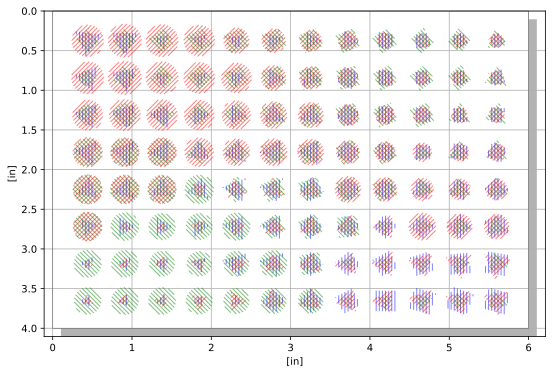

In [24]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

def circle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 16)

def diamond(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 1)

# https://stackoverflow.com/q/65544295
def triangle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    side_length = radius * math.sqrt(3)
    # Calculate three vertices of the container triangle
    a = [center[0], center[1] + (math.sqrt(3) / 3) * side_length]  # Top vertex
    b = [
        center[0] - (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]  # Bottom left vertex
display(vsk)
        center[0] + (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]  # Bottom right vertex
    return geo.Polygon([a, b, c])


shapefuncs = [diamond, circle, triangle]


MARGIN = 25
BORDER = geo.LinearRing(
    [
        (MARGIN, MARGIN),
        (MARGIN, H - MARGIN),
        (W - MARGIN, H - MARGIN),
        (W - MARGIN, MARGIN),
    ]
)
BORDER_POLYGON = geo.Polygon(BORDER)

SPACING = 45  # spacing between shapes
RADIUS = (SPACING / 2) - (SPACING * 0.025)  # "limit" of individual shape size / 2

max_dim = max(vsk.width, vsk.height)

# Backgrounds
vsk.penWidth("0.5mm")
step = vsk.strokePenWidth * 2

vertical_lines = []
diag_right_lines = []
diag_left_lines = []
# Draw vertical lines from the left to the right of the canvacs
for x in np.arange(0, max_dim, step=step):
    vertical_lines.append(geo.LineString([(x, 0), (x, max_dim)]))

diag_right_base = geo.LineString([(0, 0), (max_dim, max_dim)])
diag_right_lines = [diag_right_base]
diag_left_base = geo.LineString([(0, max_dim), (max_dim, 0)])
diag_left_lines = [diag_left_base]

for r in np.arange(step, max_dim, step=step):
    diag_right_lines.append(affinity.translate(diag_right_base, r*math.sqrt(step/2), 0))
    diag_right_lines.append(affinity.translate(diag_right_base, 0, r*math.sqrt(step/2)))
    diag_left_lines.append(affinity.translate(diag_left_base, -r*math.sqrt(step/2), 0))
    diag_left_lines.append(affinity.translate(diag_left_base, 0, r*math.sqrt(step/2)))

layer_lines = [vertical_lines, diag_right_lines, diag_left_lines]
# Creates grid of points from Start Margin to End Margin
# with each point `SPACING` apart
xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
xyrange = (xrange, yrange)
points = []
for x in xrange:
    for y in yrange:
        points.append((x, y))


def knn_grid(
    grid_points: List[Tuple[float, float]], k: int = 3, metric: str = "euclidean"
) -> List[int]:
    centers = choices(grid_points, k=k)  # choose k points to be "centers"
    neigh = NearestNeighbors(n_neighbors=1, metric=metric)
    neigh.fit(centers)  # fit knn on those centers as the 'label'
    # for each point, return the 1st nearest neighbor
    closest_point = neigh.kneighbors(points, 1, return_distance=False)
    labels = list(c[0] for c in closest_point)
    return labels


def generate_layer_shapes(
    grid_points: List[Tuple[float, float]], labels: List[int]
) -> List[geo.Polygon]:
    n_unique_labels = len(set(labels))
    print(set(labels))
    # Assign each neighborhood a shape
    label_shape_functions = {
        l: np.random.choice(shapefuncs) for l in range(n_unique_labels)
    }
    # add some arbitrary value for the noise 3rd dimension
    label_noise_start = {l: randint(0, 100) for l in range(n_unique_labels)}
    layer_shapes = []
    for (x, y), l in zip(grid_points, labels):
        vsk.stroke(l + 1)
        xn = x / (W - MARGIN)
        yn = y / (H - MARGIN)
        sfunc = label_shape_functions[l]
        shape = sfunc((x, y), RADIUS)
        noise = vsk.noise(xn, yn, label_noise_start[l])
        rotatenoise = np.interp(noise, [0, 1], [0, 359])
        if sfunc == circle:
            # circles have rotational symmetry so that variation is boring
            scalenoise = np.interp(noise, [0, 1], [0.2, 1.3])
        else:
            scalenoise = np.interp(noise, [0, 1], [0.2, 1.2])
        shape = affinity.scale(shape, scalenoise, scalenoise, origin="centroid")
        shape = affinity.rotate(shape, rotatenoise, origin="centroid")
        layer_shapes.append(shape)
    return layer_shapes


l1_shapes = generate_layer_shapes(points, knn_grid(points))
print("l1 shapes generated")
l2_shapes = generate_layer_shapes(points, knn_grid(points))
print("l2 shapes generated")
l3_shapes = generate_layer_shapes(points, knn_grid(points))
print("l3 shapes generated")

print("calc intersection 1")
vsk.stroke(1)
vertical_lines_geo = geo.MultiLineString(vertical_lines)
# # vsk.geometry(vertical_lines_geo)

for s in l1_shapes:
    # vsk.geometry(s)
    vsk.geometry(s.intersection(vertical_lines_geo))

print("calc intersection 2")
vsk.stroke(2)
# diag_right_lines_geo = affinity.rotate(vertical_lines_geo, 45, origin=(H/2, W/2))
diag_right_lines_geo = geo.MultiLineString(diag_right_lines)
# vsk.geometry(diag_right_lines_geo)

for s in l2_shapes:
    # vsk.geometry(s)
    vsk.geometry(s.intersection(diag_right_lines_geo))

# print("calc intersection 3")
vsk.stroke(3)
# # diag_left_lines_geo = affinity.rotate(vertical_lines_geo, 360-45, origin=(H/2, W/2))
diag_left_lines_geo = geo.MultiLineString(diag_left_lines)
# vsk.geometry(diag_left_lines_geo)
for s in l3_shapes:
    # vsk.geometry(s)
    vsk.geometry(s.intersection(diag_left_lines_geo))

print("Finished Calculating")
vsk.display(mode="matplotlib", fig_size=(6*1.5, 4*1.5), unit="in", grid=True)


In [118]:
vsk.vpype("linesimplify linemerge reloop linesort")
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
vsk.save(f"output/knn-shapes-teach-{timestamp}.svg")


In [20]:
len(vertical_lines)


305

288.0